# Average Face

In [1]:
import math
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import dlib
from scipy.spatial import Delaunay
from imutils import face_utils

from retinaface import RetinaFace as rf

def pp_images(imgs : list):
    _, axs = plt.subplots(1, len(imgs), figsize=(12, 12))
    for img, ax in zip(imgs, axs):
        ax.imshow(img)
    plt.show()

def cal_angle(eyedict : dict) :
    x1,y1 = eyedict['eye_l']
    x2,y2 = eyedict['eye_r']
    a = abs(y1-y2)
    b = abs(x2-x1)
    c = math.sqrt(a*a+b*b)
    cos_alpha = (b*b + c*c - a*a) / (2 * b*c)

    alpha = np.arccos(cos_alpha) #radius
    alpha = (alpha * 180)/ math.pi
    direction = -1 if y1-y2 < 0 else 1
    return alpha, direction

def get_img_tensors (img_list) :
    img_tensors = []
    for img_path in img_list:
        img = cv2.imread(img_path)
        resp = rf.detect_faces(img_path = img_path)
        eye_loc = { 'eye_l' : resp['face_1']['landmarks']['left_eye'],
                'eye_r' : resp['face_1']['landmarks']['right_eye']}
        alpha, direction = cal_angle(eye_loc)
        img_aligned = Image.fromarray(img)
        img_aligned = np.array(img_aligned.rotate(alpha*direction))
        img_tensors.append(img_aligned)
    return img_tensors

def get_landmarks(img_tensor:np.array):
    dets = detector(img_tensor)
    h,w,_ = img_size
    margin = 10
    landmarks = np.array([[margin,margin],[h-margin,margin],[margin,w-margin],[h-margin,w-margin],[h//2,margin],[h//2,w-margin],[margin,w//2],[h-margin,w//2]])
    for k, d in enumerate(dets):
        shape = predictor(img_tensor, d)
        landmarks = np.concatenate((landmarks, face_utils.shape_to_np(shape)), axis=0)
    return landmarks.astype(np.float32)

def applyAffineTransform(src, srcTri, dstTri, size) :
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )
    return dst

def get_warped(img1, img2, img, t1, t2, t, alpha=0):

    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    r = cv2.boundingRect(np.float32([t]))

    t1Rect = []
    t2Rect = []
    tRect = []

    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0)

    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * ( 1 - mask ) + imgRect * mask

def warp_image(img1, img_landmarks1, mean_landmarks, mean_delaunay_tris):
    img_warped = np.zeros(shape=img.shape, dtype=img.dtype)
    for x,y,z in mean_delaunay_tris:
        tri_1 = [img_landmarks1[x], img_landmarks1[y], img_landmarks1[z]]
        tri_m = [mean_landmarks[x], mean_landmarks[y], mean_landmarks[z]]
        get_warped(img1, img1, img_warped, tri_1, tri_1, tri_m, alpha=0.5)

    return img_warped

## Input Images

Metal device set to: Apple M1


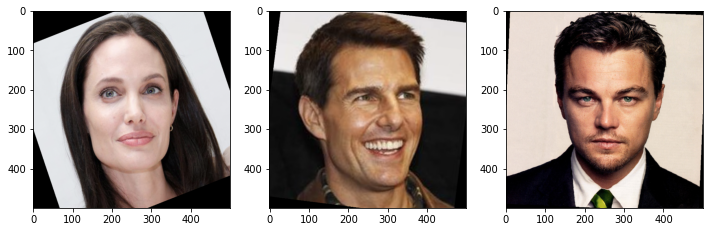

In [2]:
img_size = (500,500,3)
num_imgs = 3
img_list = ['./img_{n}.png'.format(n=i) for i in range(1,num_imgs+1)]

img_tensors = [cv2.resize(img_tensor,img_size[:2])[...,::-1] for img_tensor in get_img_tensors(img_list)]
#img_tensors = [cv2.resize(cv2.imread(img_path),img_size[:2])[...,::-1] for img_path in img_list]
pp_images(img_tensors)

In [3]:
p = './shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)
landmarks = np.array([get_landmarks(img_tensor) for img_tensor in img_tensors])

mean_landmarks = landmarks.sum(axis=0)
mean_landmarks //= len(img_list)

## Delaunay Triangulation

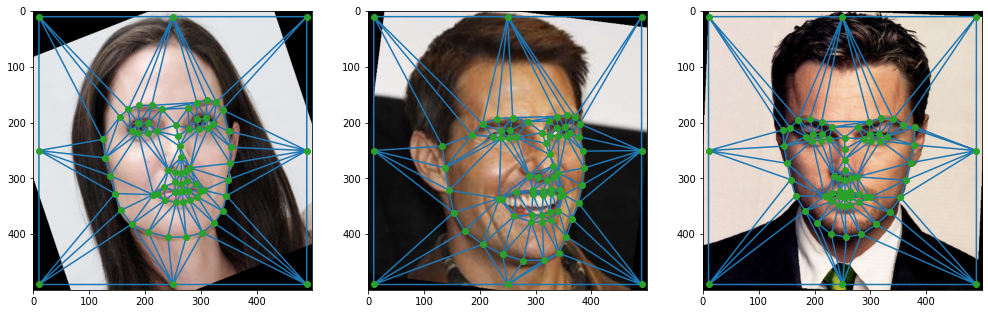

In [4]:
delaunay_tris = [Delaunay(face_landmarks).simplices for face_landmarks in landmarks]
mean_delaunay_tris = Delaunay(mean_landmarks).simplices
_, axs = plt.subplots(1, len(img_list), figsize=(17, 17))
for img, points, ax in zip(img_tensors, landmarks, axs):
    ax.imshow(img)
    ax.triplot(points[:,0], points[:,1], mean_delaunay_tris)
    ax.plot(points[:,0], points[:,1], 'o')
plt.show()

## Warping and Blending Images

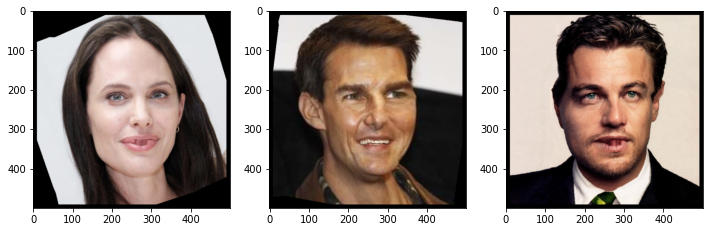

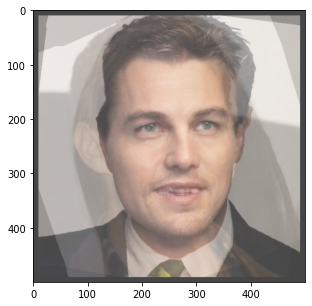

In [6]:
warped_imgs = [warp_image(img_tensors[idx],landmarks[idx], mean_landmarks, mean_delaunay_tris) for idx in range(num_imgs)]
pp_images(warped_imgs)

plt.figure(figsize=(5,5))
for i in range(num_imgs):
    plt.imshow(warped_imgs[i], alpha=0.35)

plt.show()